<a href="https://colab.research.google.com/github/mohsley/skin-cancer-detection/blob/logistic-regression/SIMlogistic_regression_skincancer_sim2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
!pip install imbalanced-learn

In [ ]:
import requests
import zipfile
import os
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


# Importing Dataset

In [ ]:
url = "https://github.com/mohsley/skin-cancer-detection/raw/refs/heads/main/data.zip"

In [ ]:
zip_file_path = "data.zip"
response = requests.get(url)
if response.status_code == 200:
    with open(zip_file_path, "wb") as file:
        file.write(response.content)
    print("ZIP file downloaded successfully.")
else:
    print(f"Failed to download the ZIP file. Status code: {response.status_code}")
    exit()

ZIP file downloaded successfully.


In [ ]:
extract_folder = "extracted_data"
os.makedirs(extract_folder, exist_ok=True)
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("ZIP file extracted successfully.")
except zipfile.BadZipFile:
    print("Error: The downloaded file is not a valid ZIP file.")

ZIP file extracted successfully.


In [ ]:
!rm "/content/data.zip"

In [ ]:
df = pd.read_csv("/content/extracted_data/data/train-metadata.csv")

<ipython-input-57-f2053e00843a>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/extracted_data/data/train-metadata.csv")


In [ ]:
df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [ ]:
df.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

In [ ]:
features_to_drop = [
    # maybe drop these, but they don't make accuracy 1 so idk
    'tbp_lv_Lext',
    'tbp_lv_deltaLB',
    'tbp_lv_location_simple',
    'tbp_lv_norm_color',
    'tbp_lv_perimeterMM',
    'tbp_lv_radial_color_std_max',

    # Clinical measurements
    'mel_thick_mm',
    'mel_mitotic_index',

    # Model confidence scores
    'tbp_lv_dnn_lesion_confidence',
    'tbp_lv_nevi_confidence',

    # IDs and metadata (not relevant for prediction)
    'iddx_full',
    'iddx_1',
    'iddx_2',
    'iddx_3',
    'iddx_4',
    'iddx_5',
    'isic_id',
    'patient_id',
    'lesion_id',
    'attribution',
    'copyright_license'
]

In [ ]:
df.drop(columns=features_to_drop,inplace=True)

In [ ]:
df.head()

,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_location,tbp_lv_minorAxisMM,tbp_lv_norm_border,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,0,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,...,Right Leg - Upper,1.543016,7.091360,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948
1,0,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,...,Head & Neck,0.821918,2.116402,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500
2,0,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,...,Torso Back Top Third,1.194905,4.798335,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900
3,0,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,...,Torso Front Top Half,2.481328,1.975874,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802
4,0,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,...,Torso Front Top Half,0.929916,3.658854,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960


In [ ]:
missing_percentages = (df.isnull().sum() / len(df)) * 100
columns_to_keep = missing_percentages[missing_percentages < 50].index
skin_cancer_df= df[columns_to_keep]
skin_cancer_df = skin_cancer_df.fillna(skin_cancer_df.mode().iloc[0])
skin_cancer_df.shape

(401059, 34)

In [ ]:
skin_cancer_df.columns

Index(['target', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_minorAxisMM',
       'tbp_lv_norm_border', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z'],
      dtype='object')

In [ ]:
skin_cancer_df.head()

,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_location,tbp_lv_minorAxisMM,tbp_lv_norm_border,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,0,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,...,Right Leg - Upper,1.543016,7.091360,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948
1,0,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,...,Head & Neck,0.821918,2.116402,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500
2,0,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,...,Torso Back Top Third,1.194905,4.798335,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900
3,0,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,...,Torso Front Top Half,2.481328,1.975874,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802
4,0,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,...,Torso Front Top Half,0.929916,3.658854,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960


In [ ]:
numerical_df = skin_cancer_df.select_dtypes(include=["number"])


In [ ]:
numerical_df.head()

,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_norm_border,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,0,60.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,...,0.901302,1.543016,7.091360,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948
1,0,60.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,...,0.639885,0.821918,2.116402,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500
2,0,60.0,3.40,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,...,0.932147,1.194905,4.798335,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900
3,0,65.0,3.22,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,...,0.654458,2.481328,1.975874,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802
4,0,55.0,2.73,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,...,0.946448,0.929916,3.658854,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960


In [ ]:
numerical_df.shape

(401059, 29)

In [ ]:
X = numerical_df.drop('target', axis=1)
y = numerical_df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print("Before SMOTE:")
print(y_train.value_counts())
print("After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Before SMOTE:
target
0    360600
1       353
Name: count, dtype: int64
After SMOTE:
target
0    360600
1    360600
Name: count, dtype: int64


In [ ]:
column_names = [f'feature_{i}' for i in range(X_train_resampled.shape[1])]  # Generate generic column names

# Convert X_train_resampled and y_train_resampled to DataFrame and Series
oversampled_data = pd.concat([
    pd.DataFrame(X_train_resampled, columns=column_names),  # Use generated column names
    pd.Series(y_train_resampled, name='target')             # Assign 'target' name to y
], axis=1)
# Sample 100,000 rows per class and combine
final_data = (oversampled_data.groupby('target')
                            .apply(lambda x: x.sample(n=100000, random_state=42))
                            .reset_index(drop=True)
                            .sample(frac=1, random_state=42))  # Shuffle data

# Split into features and target
X_final = final_data.drop(columns='target')
y_final = final_data['target']

# Verify the distribution
print("Final class distribution:")
print(y_final.value_counts())

Final class distribution:
target
1    100000
0    100000
Name: count, dtype: int64


<ipython-input-74-7a12fc845ce6>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=100000, random_state=42))


#UNDER SAMPLING

AUC for Logistic Regression: 0.8453

Confusion Matrix:
[[152  48]
 [ 16  63]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.83       200
           1       0.57      0.80      0.66        79

    accuracy                           0.77       279
   macro avg       0.74      0.78      0.74       279
weighted avg       0.81      0.77      0.78       279



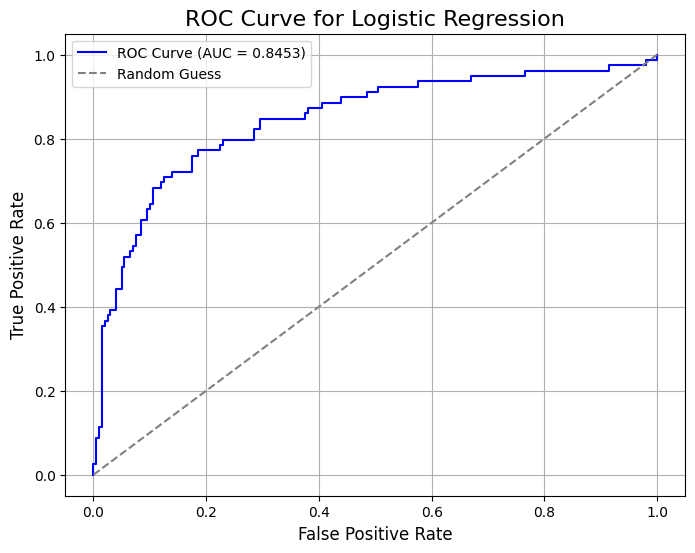

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Apply Random Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

# Train Logistic Regression model
log_reg = LogisticRegression(random_state=42, solver='liblinear')  # Use 'liblinear' for smaller datasets
log_reg.fit(X_resampled, y_resampled)

# Predictions and probabilities
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f"AUC for Logistic Regression: {roc_auc:.4f}")

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.title('ROC Curve for Logistic Regression', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(fontsize=10)
plt.grid()
plt.show()


#DATA VISUALIZATION

Cleaned data head:
    age_approx  clin_size_long_diam_mm  tbp_lv_A  tbp_lv_Aext  tbp_lv_z target
0          60                      20       0.5          1.2       -42      0
1          60                      25       0.6          1.3        57      0
2          60                      30       0.4          1.1       232      1
3          65                      15       0.7          1.5        58      1
4          55                      22       0.3          1.0        21      0
Unique values in target: ['0', '1']
Feature: age_approx, Shape: (5,)
Sample values of age_approx:
 0    60
1    60
2    60
3    65
4    55
Name: age_approx, dtype: int64


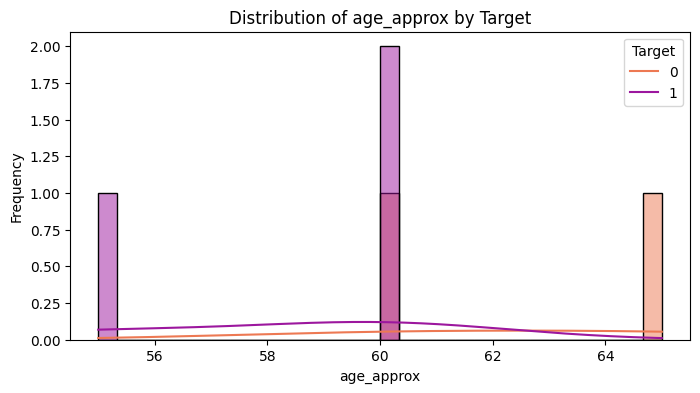

Feature: clin_size_long_diam_mm, Shape: (5,)
Sample values of clin_size_long_diam_mm:
 0    20
1    25
2    30
3    15
4    22
Name: clin_size_long_diam_mm, dtype: int64


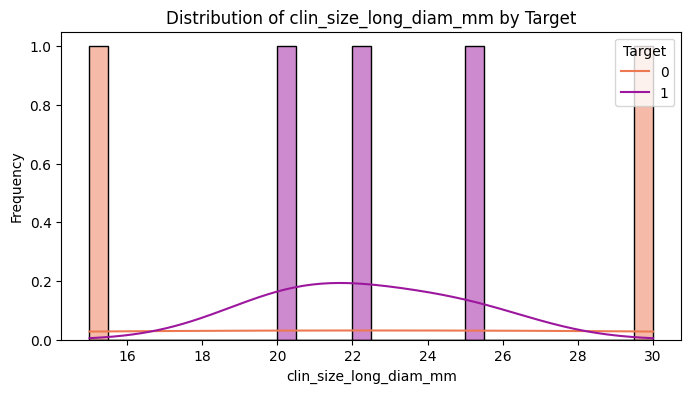

Feature: tbp_lv_A, Shape: (5,)
Sample values of tbp_lv_A:
 0    0.5
1    0.6
2    0.4
3    0.7
4    0.3
Name: tbp_lv_A, dtype: float64


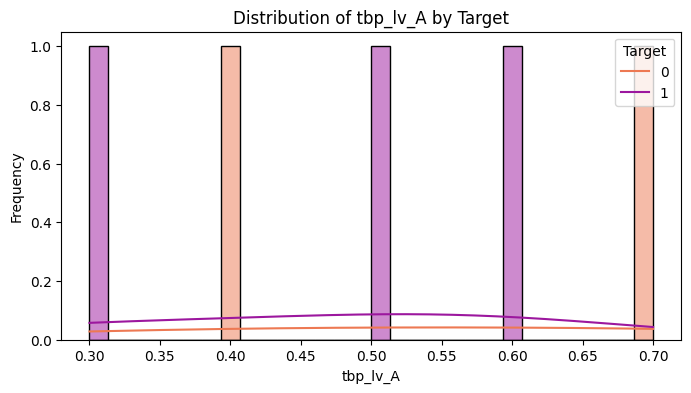

Feature: tbp_lv_Aext, Shape: (5,)
Sample values of tbp_lv_Aext:
 0    1.2
1    1.3
2    1.1
3    1.5
4    1.0
Name: tbp_lv_Aext, dtype: float64


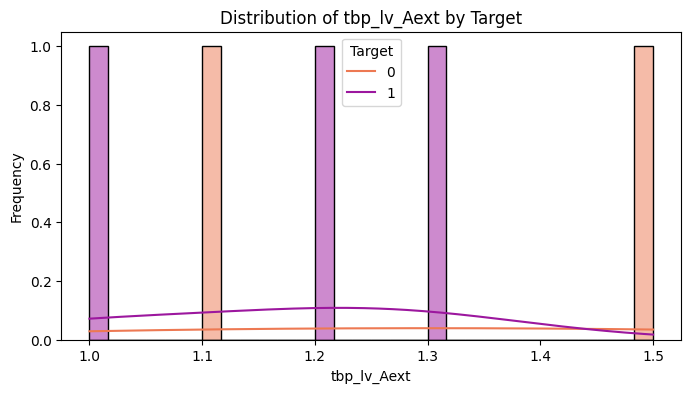

Feature: tbp_lv_z, Shape: (5,)
Sample values of tbp_lv_z:
 0    -42
1     57
2    232
3     58
4     21
Name: tbp_lv_z, dtype: int64


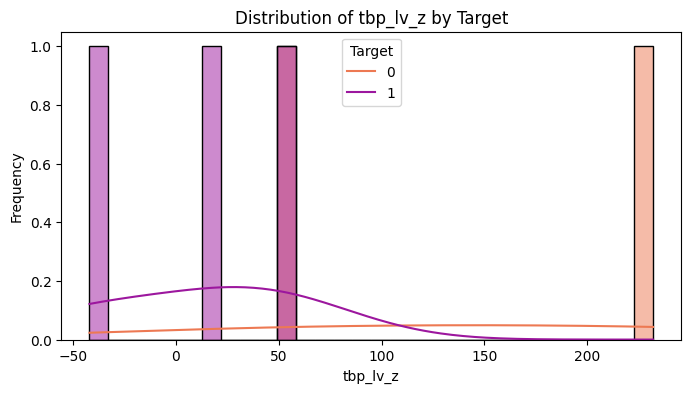

Selected columns for pairplot: ['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'target']


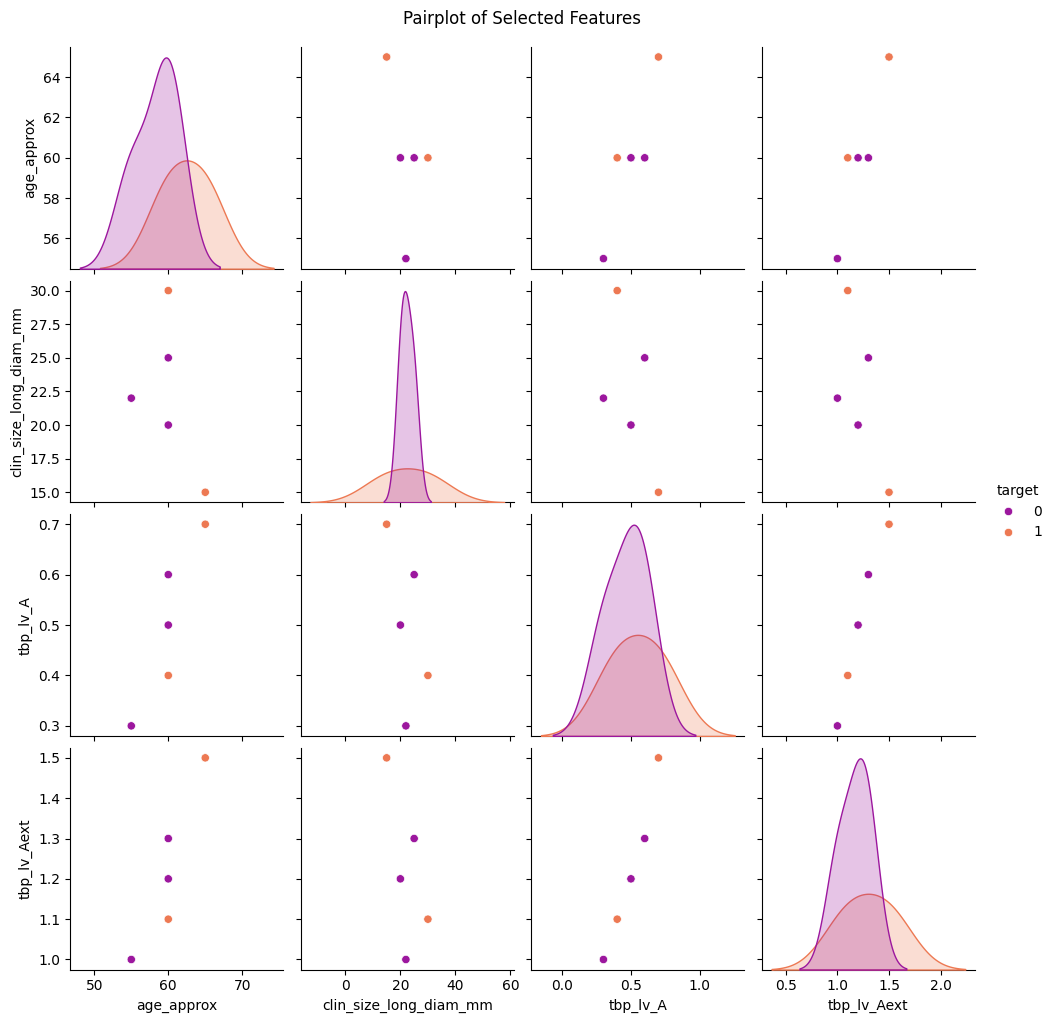

PCA Results Head:
        PCA1      PCA2 target
0  0.326287 -1.162364      0
1  0.425105  0.357685      0
2 -1.669051  1.952331      1
3  3.011301  0.212143      1
4 -2.093642 -1.359795      0


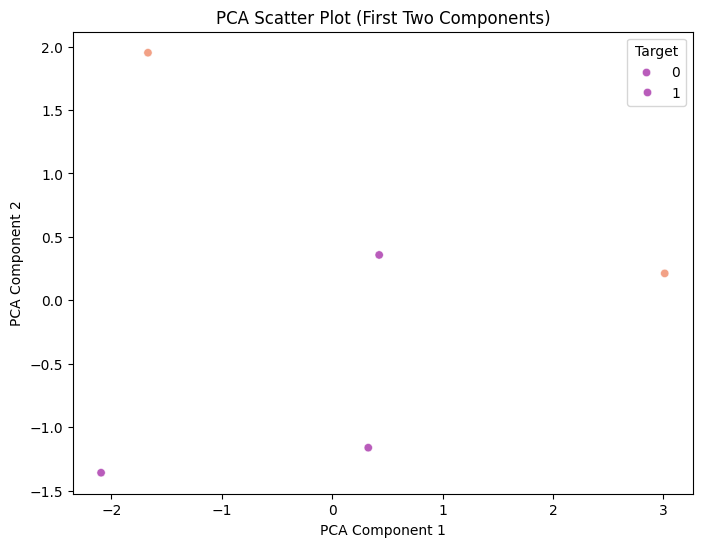

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Ensure clean_data exists for demonstration
# Replace this with your actual DataFrame loading process
clean_data = pd.DataFrame({
    'age_approx': [60, 60, 60, 65, 55],
    'clin_size_long_diam_mm': [20, 25, 30, 15, 22],
    'tbp_lv_A': [0.5, 0.6, 0.4, 0.7, 0.3],
    'tbp_lv_Aext': [1.2, 1.3, 1.1, 1.5, 1.0],
    'tbp_lv_z': [-42, 57, 232, 58, 21],
    'target': [0, 0, 1, 1, 0]
})

# Ensure 'target' is properly formatted as a string and a Series
clean_data['target'] = clean_data['target'].astype(str)  # Ensure it's a Series
print("Cleaned data head:\n", clean_data.head())

# Debugging: Check unique values in the target column using drop_duplicates()
target_values = clean_data['target'].drop_duplicates().tolist()  # Alternative to .unique()
print("Unique values in target:", target_values)

# Define numeric features
numeric_features = [
    col for col in clean_data.columns
    if clean_data[col].dtype in ['float64', 'int64', 'float32', 'int32']
]

# Visualize Numeric Features
for feature in numeric_features:
    if feature != 'target':
        print(f"Feature: {feature}, Shape: {clean_data[feature].shape}")
        print(f"Sample values of {feature}:\n", clean_data[feature].head())

        # Plot histogram
        plt.figure(figsize=(8, 4))
        sns.histplot(data=clean_data, x=feature, hue='target', kde=True, bins=30, palette='plasma')
        plt.title(f'Distribution of {feature} by Target')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend(title='Target', labels=target_values)
        plt.show()

# Pairplot for Selected Numeric Features
selected_numeric_features = numeric_features[:4] + ['target']
print("Selected columns for pairplot:", selected_numeric_features)

sns.pairplot(data=clean_data[selected_numeric_features], hue='target', palette='plasma')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

# PCA Scatter Plot
# Scale the numeric data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clean_data[numeric_features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['target'] = clean_data['target']

# Debugging PCA results
print("PCA Results Head:\n", pca_df.head())

# Scatter plot for PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df, x='PCA1', y='PCA2', hue='target', palette='plasma', alpha=0.7
)
plt.title('PCA Scatter Plot (First Two Components)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Target', labels=target_values)
plt.show()


# DATA VISUALIZATION - SUPER GRAPH

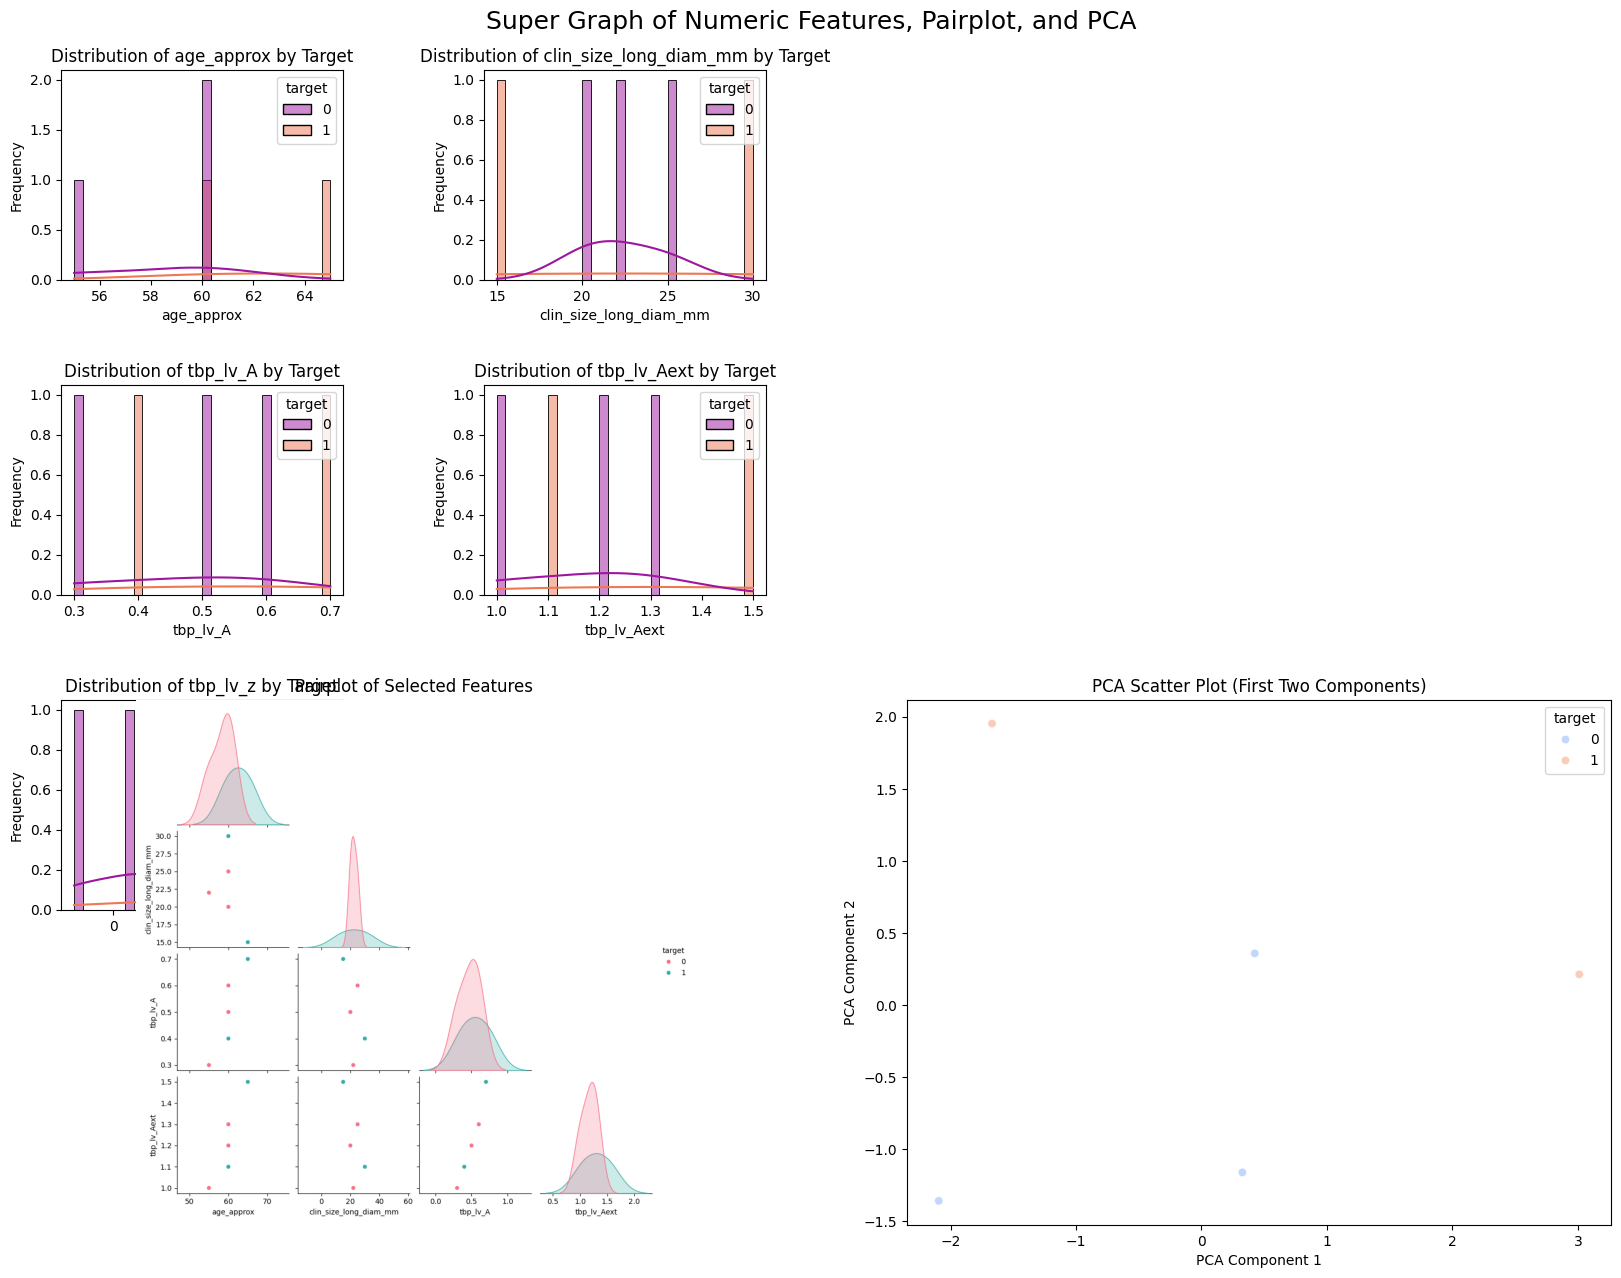

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Data Preparation
clean_data = pd.DataFrame({
    'age_approx': [60, 60, 60, 65, 55],
    'clin_size_long_diam_mm': [20, 25, 30, 15, 22],
    'tbp_lv_A': [0.5, 0.6, 0.4, 0.7, 0.3],
    'tbp_lv_Aext': [1.2, 1.3, 1.1, 1.5, 1.0],
    'tbp_lv_z': [-42, 57, 232, 58, 21],
    'target': [0, 0, 1, 1, 0]
})
clean_data['target'] = clean_data['target'].astype(str)

# Define numeric features
numeric_features = [
    col for col in clean_data.columns
    if clean_data[col].dtype in ['float64', 'int64', 'float32', 'int32']
]

# PCA Preparation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clean_data[numeric_features])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['target'] = clean_data['target']

# Create Super Graph
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(4, 4)  # Define a 4x4 grid layout
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Add Histograms
for i, feature in enumerate(numeric_features):
    ax = fig.add_subplot(gs[i // 2, i % 2])  # Place in grid
    sns.histplot(data=clean_data, x=feature, hue='target', kde=True, bins=30, palette='plasma', ax=ax)
    ax.set_title(f'Distribution of {feature} by Target')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Pairplot: Save and Embed
selected_numeric_features = numeric_features[:4] + ['target']
pairplot = sns.pairplot(data=clean_data[selected_numeric_features], hue='target', palette='husl', diag_kind='kde', corner=True)
pairplot.fig.savefig('pairplot.png')  # Save as image
plt.close(pairplot.fig)  # Close standalone pairplot figure

# Add Pairplot Image to Super Graph
from matplotlib.image import imread
pairplot_ax = fig.add_subplot(gs[2:, :2])  # Reserve space for pairplot
img = imread('pairplot.png')
pairplot_ax.imshow(img)
pairplot_ax.axis('off')
pairplot_ax.set_title('Pairplot of Selected Features')

# PCA Scatter Plot
ax_pca = fig.add_subplot(gs[2:, 2:])  # Reserve space for PCA plot
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='target', palette='coolwarm', alpha=0.7, ax=ax_pca)
ax_pca.set_title('PCA Scatter Plot (First Two Components)')
ax_pca.set_xlabel('PCA Component 1')
ax_pca.set_ylabel('PCA Component 2')

# Final Super Graph Title
plt.suptitle('Super Graph of Numeric Features, Pairplot, and PCA', fontsize=18, y=0.92)
plt.show()


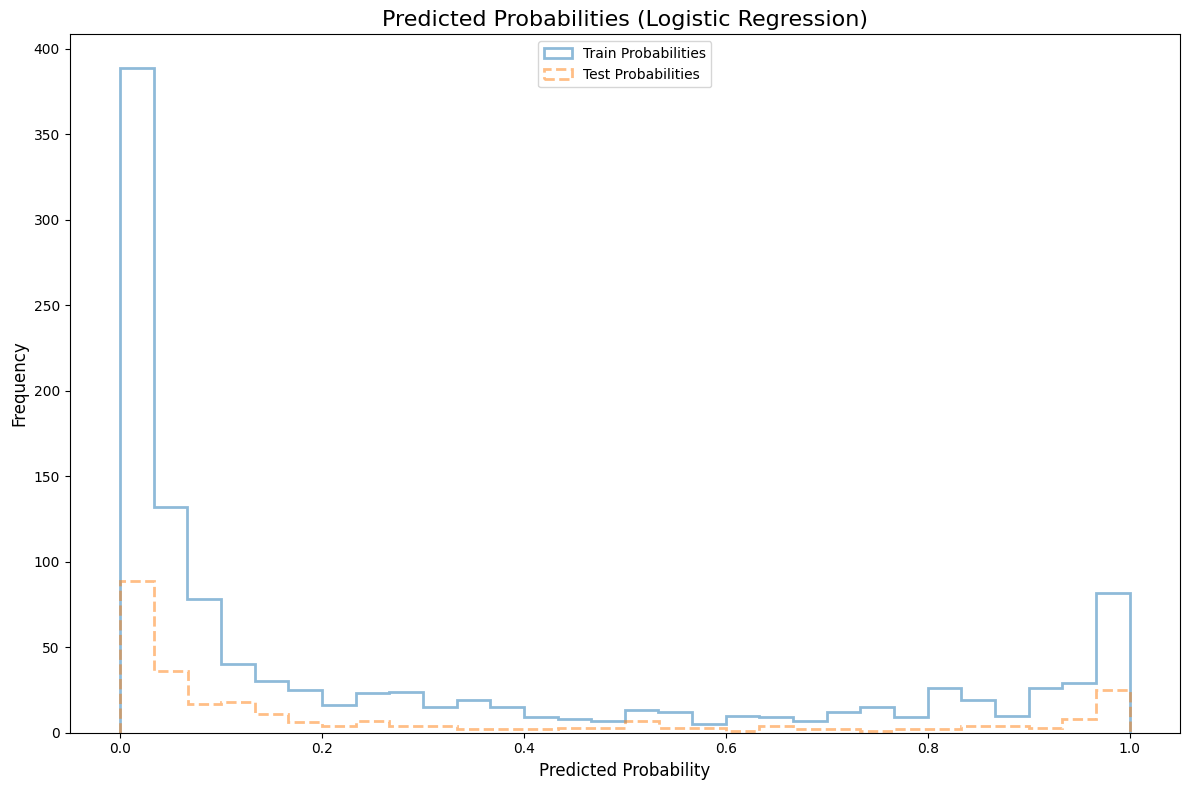

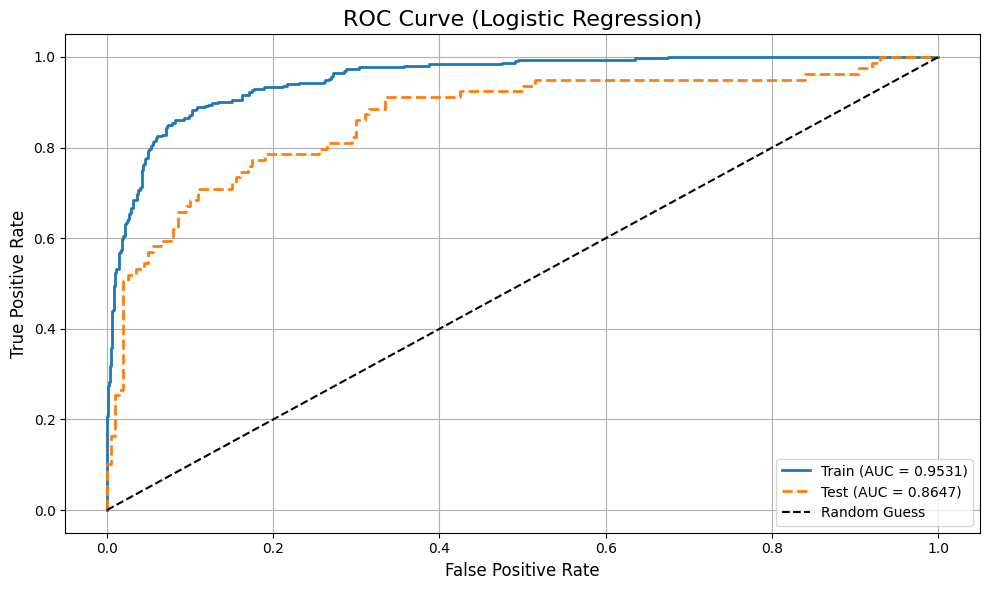

In [104]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

# Step 1: Scale the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scale training data
X_test_scaled = scaler.transform(X_test)       # Scale testing data

# Step 2: Train Logistic Regression with Increased max_iter
log_reg = LogisticRegression(random_state=42, max_iter=500)  # Increase max_iter
log_reg.fit(X_train_scaled, y_train)

# Step 3: Predicted Probabilities
y_train_proba = log_reg.predict_proba(X_train_scaled)[:, 1]  # Probability for positive class (Train)
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]    # Probability for positive class (Test)

# Step 4: Plot Predicted Probabilities Distributions
plt.figure(figsize=(12, 8))
plt.hist(y_train_proba, bins=30, alpha=0.5, label='Train Probabilities', histtype='step', linewidth=2)
plt.hist(y_test_proba, bins=30, alpha=0.5, label='Test Probabilities', histtype='step', linestyle='--', linewidth=2)

plt.title('Predicted Probabilities (Logistic Regression)', fontsize=16)
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10, loc='upper center')
plt.tight_layout()
plt.show()

# Step 5: Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc(fpr_train, tpr_train):.4f})', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc(fpr_test, tpr_test):.4f})', linestyle='--', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.title('ROC Curve (Logistic Regression)', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(fontsize=10)
plt.grid()
plt.tight_layout()
plt.show()


# Logistic Regression

In [ ]:
roc_data = []

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Accuracy: 0.84
ROC AUC: 0.92


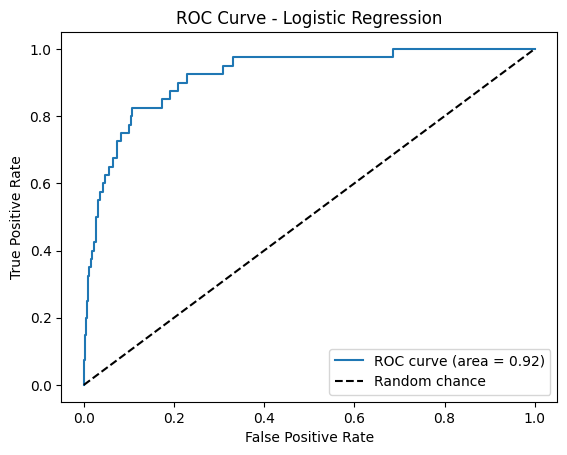

In [ ]:

from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Train the model
log_reg.fit(X_final, y_final)

# Predict and evaluate
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
y_proba = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)  # ROC components
roc_auc = auc(fpr, tpr)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


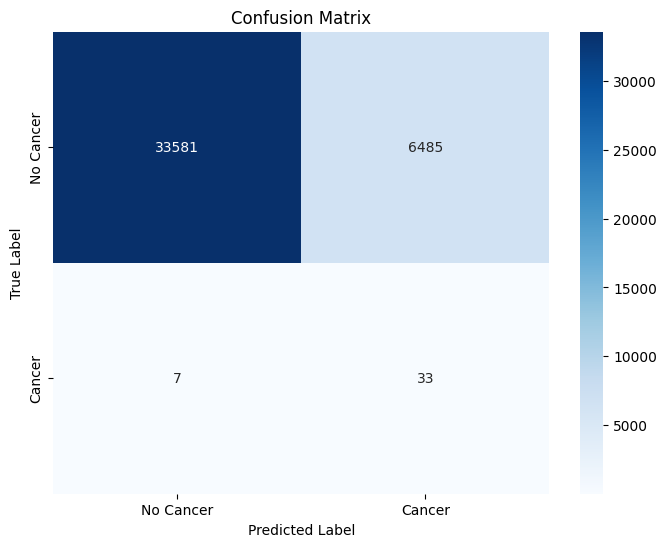

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#IMAGE FILES

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"simkapoor","key":"c2308805fca8940b5c7884b90d568b83"}'}

In [ ]:
!ls /content/extracted_data/data/kaggle/


ls: cannot access '/content/extracted_data/data/kaggle/': No such file or directory


In [ ]:
!pip install kaggle --upgrade


In [ ]:
import os

# Create the .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# # Move kaggle.json to the correct directory
!mv kaggle.json /root/.kaggle/

# Set the correct permissions
!chmod 600 /root/kaggle/kaggle.json
# !chmod +x /usr/local/bin/kaggle


# !chmod 600 /usr/local/bin/kaggle

chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [ ]:
%cd '/content/extracted_data/data'


/content/extracted_data/data


In [ ]:
!kaggle competitions download -c isic-2024-challenge


100% 1.99G/2.00G [00:33<00:00, 111MB/s]
100% 2.00G/2.00G [00:33<00:00, 64.3MB/s]


In [ ]:
!unzip "/content/extracted_data/data/isic-2024-challenge.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train-image/image/ISIC_9874656.jpg  
  inflating: train-image/image/ISIC_9874659.jpg  
  inflating: train-image/image/ISIC_9874663.jpg  
  inflating: train-image/image/ISIC_9874742.jpg  
  inflating: train-image/image/ISIC_9874751.jpg  
  inflating: train-image/image/ISIC_9874803.jpg  
  inflating: train-image/image/ISIC_9874805.jpg  
  inflating: train-image/image/ISIC_9874832.jpg  
  inflating: train-image/image/ISIC_9874878.jpg  
  inflating: train-image/image/ISIC_9874897.jpg  
  inflating: train-image/image/ISIC_9874925.jpg  
  inflating: train-image/image/ISIC_9874931.jpg  
  inflating: train-image/image/ISIC_9874939.jpg  
  inflating: train-image/image/ISIC_9874940.jpg  
  inflating: train-image/image/ISIC_9874963.jpg  
  inflating: train-image/image/ISIC_9874987.jpg  
  inflating: train-image/image/ISIC_9875007.jpg  
  inflating: train-image/image/ISIC_9875010.jpg  
  inflating: train-image/image/ISIC_9875033.jpg  

In [ ]:
!rm  "/content/extracted_data/data/isic-2024-challenge.zip"

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import os
from tqdm import tqdm

df = pd.read_csv("/content/extracted_data/data/train-metadata.csv", low_memory=False)

class_0 = df[df['target'] == 0]
class_1 = df[df['target'] == 1]
class_0_sampled = class_0.sample(n=1000, random_state=42)
subset_df = pd.concat([class_0_sampled, class_1])

print(f"Class 0 samples: {len(class_0_sampled)}")
print(f"Class 1 samples: {len(class_1)}")
print(f"Total samples: {len(subset_df)}")

missing_percentages = (subset_df.isnull().sum() / len(subset_df)) * 100
columns_to_keep = missing_percentages[missing_percentages < 50].index
skin_cancer_df = subset_df[columns_to_keep]

features_to_drop = [
    'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
    'patient_id', 'lesion_id', 'attribution', 'copyright_license'
]

skin_cancer_df = skin_cancer_df.drop(columns=[col for col in features_to_drop if col in skin_cancer_df.columns])

numeric_columns = skin_cancer_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = skin_cancer_df.select_dtypes(include=['object', 'category']).columns

skin_cancer_df[numeric_columns] = skin_cancer_df[numeric_columns].fillna(skin_cancer_df[numeric_columns].median())
skin_cancer_df[categorical_columns] = skin_cancer_df[categorical_columns].fillna(skin_cancer_df[categorical_columns].mode().iloc[0])

for col in categorical_columns:
    if col != 'isic_id':
        le = LabelEncoder()
        skin_cancer_df[col] = le.fit_transform(skin_cancer_df[col])

expected_samples = len(skin_cancer_df)
image_features = np.zeros((expected_samples, 128 * 128 * 3))
valid_indices = []

for idx, isic_id in tqdm(enumerate(skin_cancer_df['isic_id']), total=expected_samples):
    try:
        file_path = os.path.join("/content/extracted_data/data/train-image/image", f"{isic_id}.jpg")
        if os.path.exists(file_path):
            img = mpimg.imread(file_path)
            img_resized = np.array(Image.fromarray(img).resize((128, 128)))
            image_features[idx] = img_resized.reshape(-1)
            valid_indices.append(idx)
    except Exception as e:
        print(f"Error processing {isic_id}: {str(e)}")
        continue

if not valid_indices:
    raise ValueError("No valid images were processed")

image_features = image_features[valid_indices]
image_features_scaled = image_features / 255.0

n_components = 100
pca = PCA(n_components=n_components, random_state=42)
image_features_pca = pca.fit_transform(image_features_scaled)

pca_columns = [f'pca_{i}' for i in range(n_components)]
image_df = pd.DataFrame(image_features_pca, columns=pca_columns)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"\nVariance explained by {n_components} components: {explained_variance[-1]}")

skin_cancer_df = skin_cancer_df.iloc[valid_indices]
X = pd.concat([
    skin_cancer_df.drop(['isic_id', 'target'], axis=1).reset_index(drop=True),
    image_df
], axis=1)
y = skin_cancer_df['target'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Class 0 samples: 1000
Class 1 samples: 393
Total samples: 1393


100%|██████████| 1393/1393 [00:02<00:00, 675.22it/s]



Variance explained by 100 components: 0.9518768568319043


#UNDER SAMPLING

AUC for Logistic Regression: 0.8453

Confusion Matrix:
[[152  48]
 [ 16  63]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.83       200
           1       0.57      0.80      0.66        79

    accuracy                           0.77       279
   macro avg       0.74      0.78      0.74       279
weighted avg       0.81      0.77      0.78       279



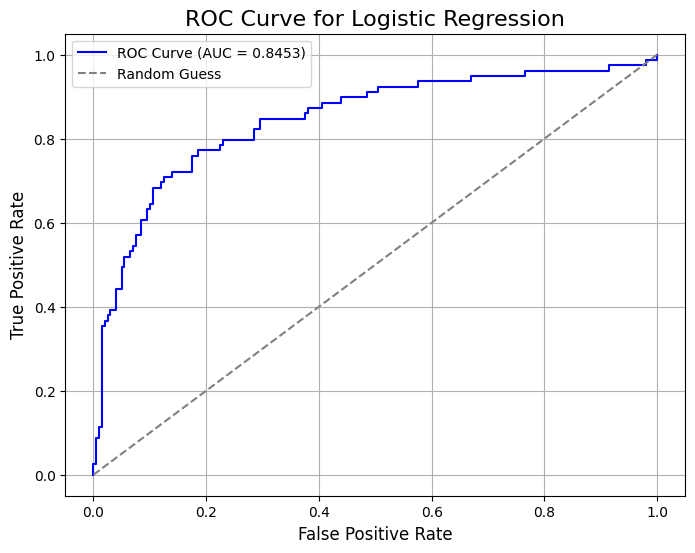

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Apply Random Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

# Train Logistic Regression model
log_reg = LogisticRegression(random_state=42, solver='liblinear')  # Use 'liblinear' for smaller datasets
log_reg.fit(X_resampled, y_resampled)

# Predictions and probabilities
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f"AUC for Logistic Regression: {roc_auc:.4f}")

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.title('ROC Curve for Logistic Regression', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(fontsize=10)
plt.grid()
plt.show()


Accuracy: 0.84
ROC AUC: 0.88


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


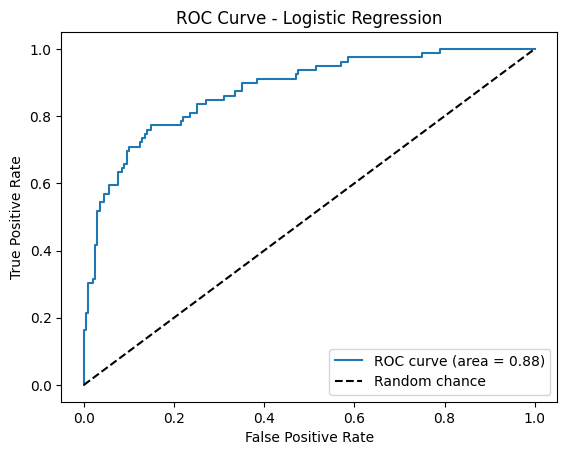

In [ ]:
roc_data = []
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Train the model using X_train and y_train (original training data)
log_reg.fit(X_train, y_train)  # Change here

# Predict and evaluate using X_test (test data with original feature names)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
y_proba = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)  # ROC components
roc_auc = auc(fpr, tpr)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()



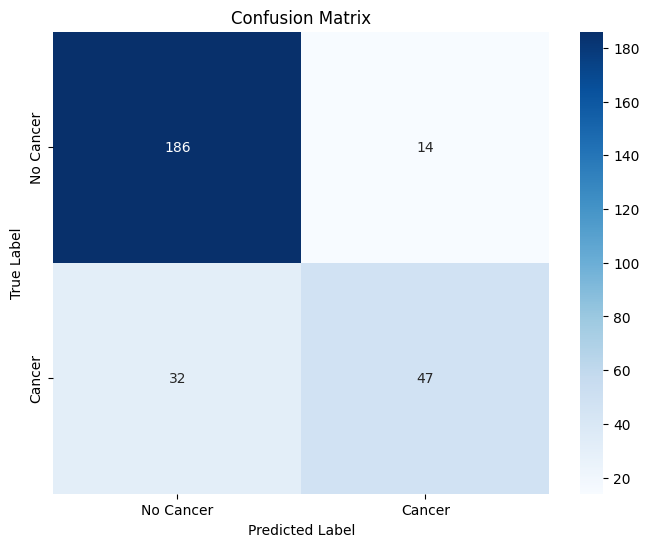

In [ ]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()